# DNN for GW parameter estimation
GW waveform template obtained from Wenfan
Try to create a GW waveform template bank with TianQin noise and train a DNN model to estiamte GW parameter space and compare it with traditional MCMC method.

In [1]:
'''
code below offered by Wenfan.
2020/12/25
Merry Chrismas
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from scipy import signal
from scipy.fftpack import fft,ifft
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

In [2]:
def ht_respon_TQ(t, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
    
    """
    For TianQin (one Michelson interferometer): (thetaS,phiS) is location of source,
    (thJ,phJ) is latitude and longitude of J0806 in heliocentric-ecliptic frame
    """
    
    thJ  = 1.65273
    phJ  = 2.10213
    kap = 2*np.pi/OrbitPeriodInS* t
    Dplus_TQ = np.sqrt(3.)/32*(8*np.cos(2*kap) *((3 + np.cos(2*thetaS)) *np.sin(2*(phiS - phJ))*  
            np.cos(thJ) + 2*np.sin(thJ) *np.sin(phiS - phJ)*np.sin(2*thetaS))- 2*np.sin(2*kap)* (3 +               
            np.cos(2*(phiS - phJ))*(9 + np.cos(2*thetaS)*(3 + np.cos(2*thJ))) -6 *np.cos(2*thJ)*(np.sin(phiS - phJ))**2 -               
            6* np.cos(2*thetaS)*(np.sin(thJ))**2 + 4*np.cos(phiS - phJ)*np.sin(2*thJ)*np.sin(2*thetaS))) 
    
    Dcros_TQ = np.sqrt(3.)/4*(-4*np.cos(2*kap)*(np.cos(2*(phiS-phJ))*np.cos(thJ)*np.cos(thetaS)+                 
            np.cos(phiS-phJ)*np.sin(thetaS)*np.sin(thJ))+np.sin(2*kap)*(np.cos(thetaS)*(3+np.cos(2*thJ))*np.sin(2*(phJ-phiS))+                
            2*np.sin(phJ-phiS)*np.sin(thetaS)*np.sin(2*thJ)))

    #"""antenna pattern function for '+' mode"""
    Fplus_TQ = (np.cos(2*psi)*Dplus_TQ-np.sin(2*psi)*Dcros_TQ)/2.

    #"""antenna pattern function for '×' mode"""
    Fcros_TQ = (np.sin(2*psi)*Dplus_TQ+np.cos(2*psi)*Dcros_TQ)/2.

    #"""1st MI angular response function for TianQin"""
    Q_TQ = np.sqrt((1+(np.cos(iota))**2)**2/4*(Fplus_TQ)**2 
             +(np.cos(iota))**2*(Fcros_TQ)**2)

    #"""1st MI polarization phase for TianQin"""
    phip_TQ = -np.arctan(2*np.cos(iota)*Fcros_TQ/((1+(np.cos(iota))**2)*Fplus_TQ))  

    #"""non-precesnp.sing spinning PN correction to the orbital phase"""
    THETA = eta*(tc-t)/(5*mc/eta**(3./5))
    PSI_PN = phic-THETA**(5./8)/eta *(1 \
           + (3715./8064 + 55./96*eta)*THETA**(-1./4) \
           - 3*np.pi/4*THETA**(-3./8)  \
           + (9275495./14450688+284875./258048*eta+1855./2048*eta**2)*THETA**(-1./2)) 

    # """the frequency-domain amplitude: 1st 60 degree MI with antenna response (contain plus and cross mode) for TianQin"""
    ht_TQ = -mc*Q_TQ/dl*((tc-t)/(5*mc))**(-1./4)*np.cos(phip_TQ+2*PSI_PN)
#     ht_TQ = np.concatenate([ht_TQ, len(t)*[0]])
    return ht_TQ

In [3]:
def ht_respon_LISA(t, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
    # set up constants
    c = 1
    G = 1
    
    """For LISA (one Michelson interferometer): (thetaS,phiS) is location of source"""
#     alpha = 2*np.pi/YearInS* t-np.pi/9 # trailing 20°behind the Earth (-np.pi/9)
    alpha = 2*np.pi/YearInS* t 
    lam = 3*np.pi/4
    Dplus_LISA = np.sqrt(3.)/64*(-36*(np.sin(thetaS))**2 *np.sin(2*alpha-2*lam) +(3+np.cos(2*thetaS))*(np.cos(2*phiS)*(9*np.sin(2*lam)-np.sin(4*alpha-2*lam))
            + np.sin(2*phiS)*(np.cos(4*alpha-2*lam)-9*np.cos(2*lam)))-4*np.sqrt(3.)*np.sin(2*thetaS)*(np.sin(3*alpha-2*lam-phiS)-3*np.sin(alpha-2*lam+phiS)))
    
    Dcros_LISA = 1/16*(np.sqrt(3.)*np.cos(thetaS)*(9*np.cos(2*lam-2*phiS)-np.cos(4*alpha-2*lam-2*phiS))-6*np.sin(thetaS)*(np.cos(3*alpha-2*lam-phiS)+3*np.cos(alpha-2*lam+phiS)))
    
    #"""antenna pattern function for '+' mode"""
    Fplus_LISA = (np.cos(2*psi)*Dplus_LISA-np.sin(2*psi)*Dcros_LISA)/2.

    #"""antenna pattern function for '×' mode"""
    Fcros_LISA = (np.sin(2*psi)*Dplus_LISA+np.cos(2*psi)*Dcros_LISA)/2.

    #"""1st MI angular response function for TianQin"""
    Q_LISA = np.sqrt((1+(np.cos(iota))**2)**2/4*(Fplus_LISA)**2 
             +(np.cos(iota))**2*(Fcros_LISA)**2)

    #"""1st MI polarization phase for TianQin"""
    phip_LISA = -np.arctan(2*np.cos(iota)*Fcros_LISA/((1+(np.cos(iota))**2)*Fplus_LISA))  

    #"""non-precesnp.np.sing spinning PN correction to the GW phase"""
    THETA = eta*(tc-t)/(5*mc/eta**(3./5))
    PSI_PN = phic-THETA**(5./8)/eta *(1 \
           + (3715./8064 + 55./96*eta)*THETA**(-1./4) \
           - 3*np.pi/4*THETA**(-3./8)  \
           + (9275495./14450688+284875./258048*eta+1855./2048*eta**2)*THETA**(-1./2)) 

    """the frequency-domain amplitude: 1st 60 degree MI with antenna response (contain plus and cross mode) for TianQin"""
    ht_LISA = -mc*Q_LISA/dl*((tc-t)/(5*mc))**(-1./4)*np.cos(phip_LISA+2*PSI_PN)
    # m is the total mass, express m in terms of mc and eta
    m = mc/eta**(3/5)
    f_iso = c**3/(G*m*np.pi*6**(3/2)) #最内稳定圆轨道的引力波频率
    tau = c**3 * eta / (5 * G * m) * (tc - t)
    w = c**3 / (8 * G * m) * (tau**(-3/8) + (743 / 2688 + 11 / 32 * eta) * tau**(-5/8) - 3 * np.pi / 10 * tau**(-3/4) +
        (1855099 / 14450688 + 56975 / 258048 * eta + 371 / 2048 * eta**2) * tau**(-7/8))
    # print(f'max orbital frequency: {max(w)}, innermost stable circular orbit frequency: {f_iso*np.pi}')
    # if any(x >= f_iso*np.pi for x in w):
    #     print(f'Orbital frequency exceeds the innermost stable circular orbit frequency, cutoff at {f_iso*np.pi} Hz.')
    #     index = next(i for i, x in enumerate(w) if x >= f_iso*np.pi)
    #     ht_LISA[index:-1]=0
    # find the index of the max(w)
    index = np.argmax(w)
    ht_LISA[index-10:]=0

    return ht_LISA

In [4]:
# def ht_model(t, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
#     ht = np.piecewise(t, [t >= tc, t < tc], 
#                       [0, partial(ht_respon_TQ, tc=tc, phic=phic, mc=mc, eta=eta, dl=dl, thetaS=thetaS, phiS=phiS, iota=iota, psi=psi)])
#     return ht

def ht_model(t, tc, phic, mc, eta, dl, thetaS, phiS, iota, psi):
    ht = np.piecewise(t, [t >= tc, t < tc], 
                      [0, partial(ht_respon_LISA, tc=tc, phic=phic, mc=mc, eta=eta, dl=dl, thetaS=thetaS, phiS=phiS, iota=iota, psi=psi)])
    return ht

# Convert noise PSD to time series PSD -> n(t)

In [5]:
def TQPSD(f):
    """CQG 2018"""
    Sx = 1e-24
    Sa = 1e-30
    L0 = np.sqrt(3.)*1e5 *1e3
    return (Sx/(L0**2)+ 4*Sa/((2*np.pi*f)**4*L0**2)*(1.+ 1e-4/f))

def LISAPSD(f):
    """MCMC of SMBHB, Cornish and Porter, CQG 2006"""
    Spos = 4e-22
    Sacc = 9e-30
    L = 5e9
    return (4*Spos+ 16*Sacc/(2*np.pi*f)**4)/(4*L**2)

# Calculate SNR

In [6]:
# calculate the SNR
def SNR(data, T, fs, detector='LISA'):
    '''
    计算数据Data的单边功率谱密度:
    T: 数据的时间长度
    fs: 数据的采样频率
    PSD: 天琴或者 LISA
    '''
    if detector == 'TQ':
        PSD = TQPSD
    elif detector == 'LISA':
        PSD = LISAPSD
    else:
        print('PSD must be TQ or LISA')
        return 0
    N = len(data)
    delta_f = 1/T
    f = np.arange(0,fs/2,delta_f)
    # print(f'total number of points {N}, length of frequency {len(f)}')
    psd = PSD(f[1:])
    xf = np.fft.fft(data)
    absf = np.abs(xf)[N//2:]/fs # single-sided spectrum
    # print(f'length of PSD {len(psd)}\n length of Pxx {len(Pxx)}')
    SNR = np.sqrt(4*np.sum(absf[1:]**2/psd*delta_f))
    return SNR

## Use white noise to generate colored noise with given PSD

In [7]:
YearInS  = (1 * u.yr).to(u.s).value  # one year in [s]
fs = 0.05 # sampling frequency
T = int(1/6*YearInS) # Total time
N = int(T*fs) # Number of data length
t = np.linspace(0,T,N) # time vector
# calculate f
df = 1/T # frequency resolution
# f = np.arange(0,fs/2,df) # frequency vector
f = np.linspace(0, fs/2, N//2 + 1) # frequency vector
print(f'number of f {len(f)}, t {len(t)/2}')
# calculate PSD and convert it to two-sided PSD
PSD = LISAPSD(f)
PSD[0] = 0 # set the DC part to zero
PSD2 = np.concatenate([PSD, np.conj(PSD[N%2-2:0:-1])])/2 # double-side PSD

print(f'length of PSD {len(PSD)}, length of two-sided {len(PSD2)}, total number of points {N}')

# generate a white noise realization
w_noise = np.random.randn(len(PSD2))*np.sqrt(fs)
# calculate the noise spectrum
fft_w_noise = np.fft.fft(w_noise)
print(f'length of fft_noise {len(fft_w_noise)}')
# multiply the spectrum by the square root of the PSD
fft_noise = fft_w_noise*np.sqrt(PSD2)
# calculate the inverse FFT
noise = np.real(np.fft.ifft(fft_noise))
print(f'length of noise {len(noise)}')
# calculate the noise spectrum
freq, Pxx = signal.periodogram(noise,fs)
print(f'length of freq axis {len(freq)}')

# PSD of white noise
freq2, Pxx2 = signal.periodogram(w_noise,fs)

number of f 131491, t 131490.0
length of PSD 131491, length of two-sided 262980, total number of points 262980
length of fft_noise 262980
length of noise 262980
length of freq axis 131491


/var/folders/8j/473p19jj4vd201q3fw1x8flw0000gn/T/ipykernel_40439/1951609304.py:13: RuntimeWarning: divide by zero encountered in divide
  return (4*Spos+ 16*Sacc/(2*np.pi*f)**4)/(4*L**2)


In [8]:
# PSD2

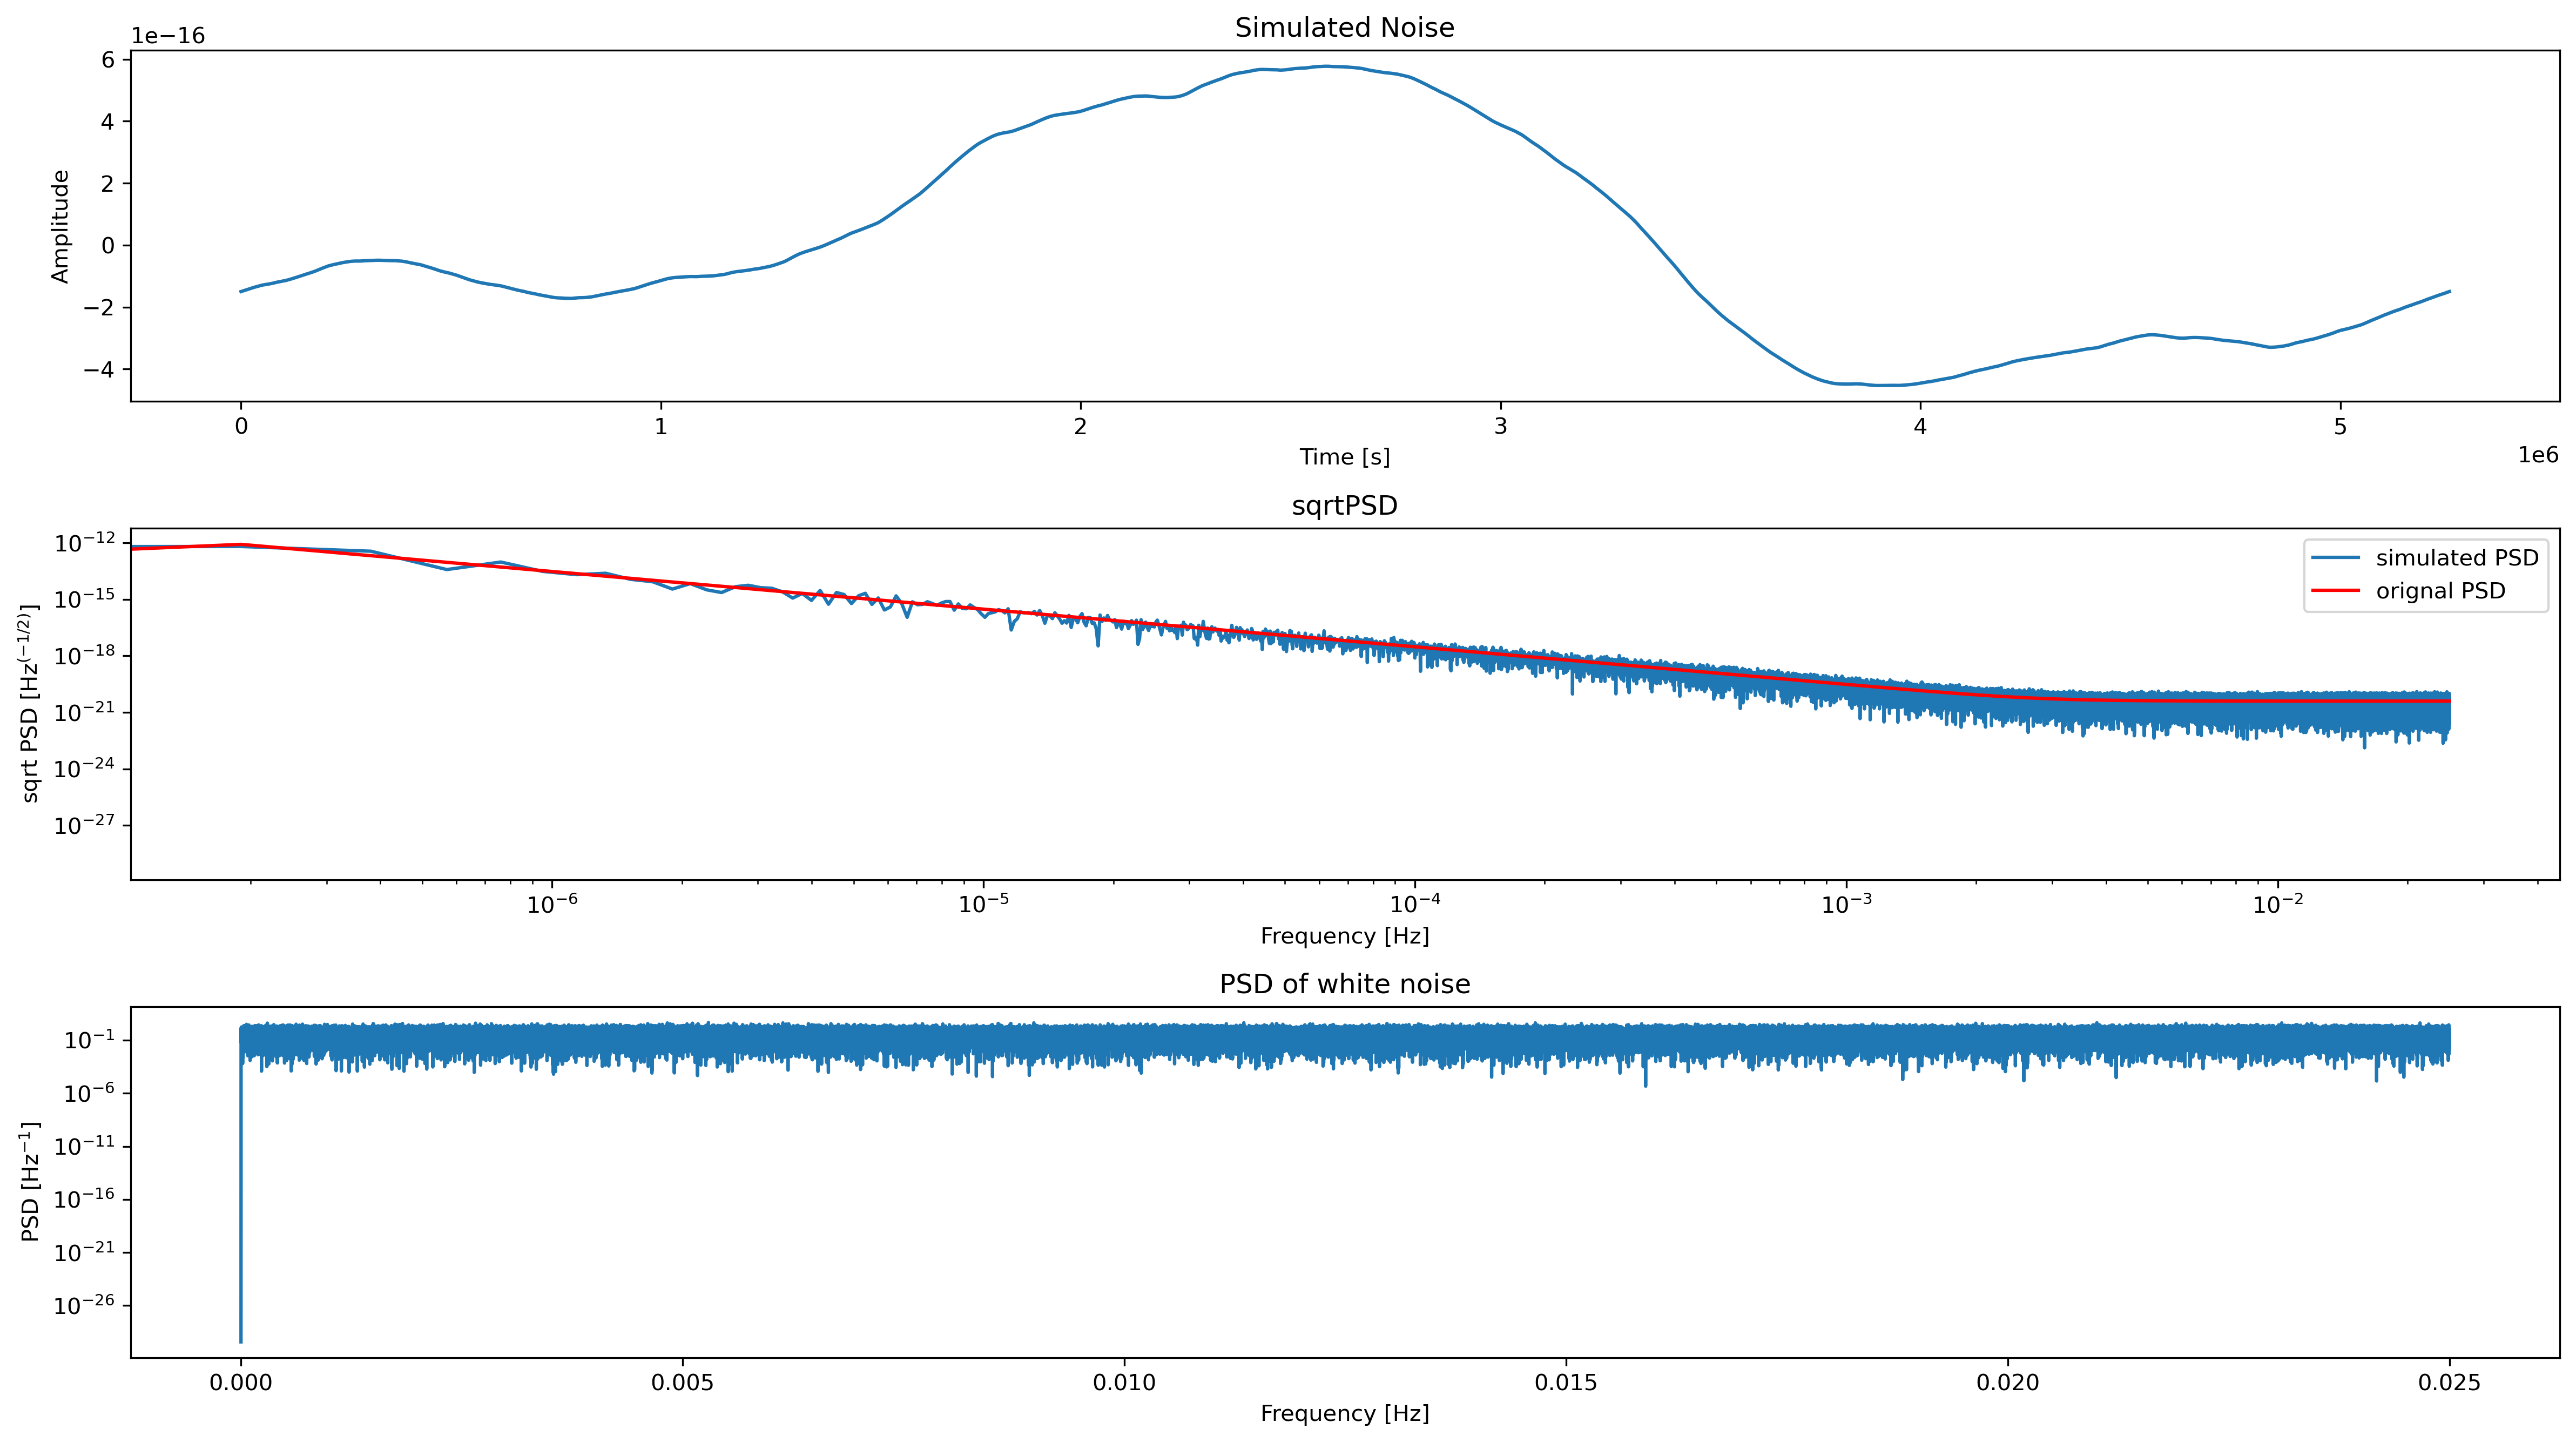

In [9]:
# plot the time series and the spectrum of the noise
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,9),dpi=300)
ax1.plot(t,noise)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude')
ax1.set_title('Simulated Noise')
ax2.loglog(freq[:N//2], np.sqrt(Pxx[:N//2]), label='simulated PSD')
# plot the original PSD
ax2.loglog(f,np.sqrt(PSD),'r',label='orignal PSD')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('sqrt PSD [Hz$^{(-1/2)}$]')
ax2.set_title('sqrtPSD')
ax2.legend()
ax3.semilogy(freq2, Pxx2*np.sqrt(fs), label='white noise')
ax3.set_xlabel('Frequency [Hz]')
ax3.set_ylabel('PSD [Hz$^{-1}$]')
ax3.set_title('PSD of white noise')
plt.tight_layout()
plt.savefig('Sim-Noise-fs-' + str(fs) + '.png', dpi=300)

# Data Model
## constants set up

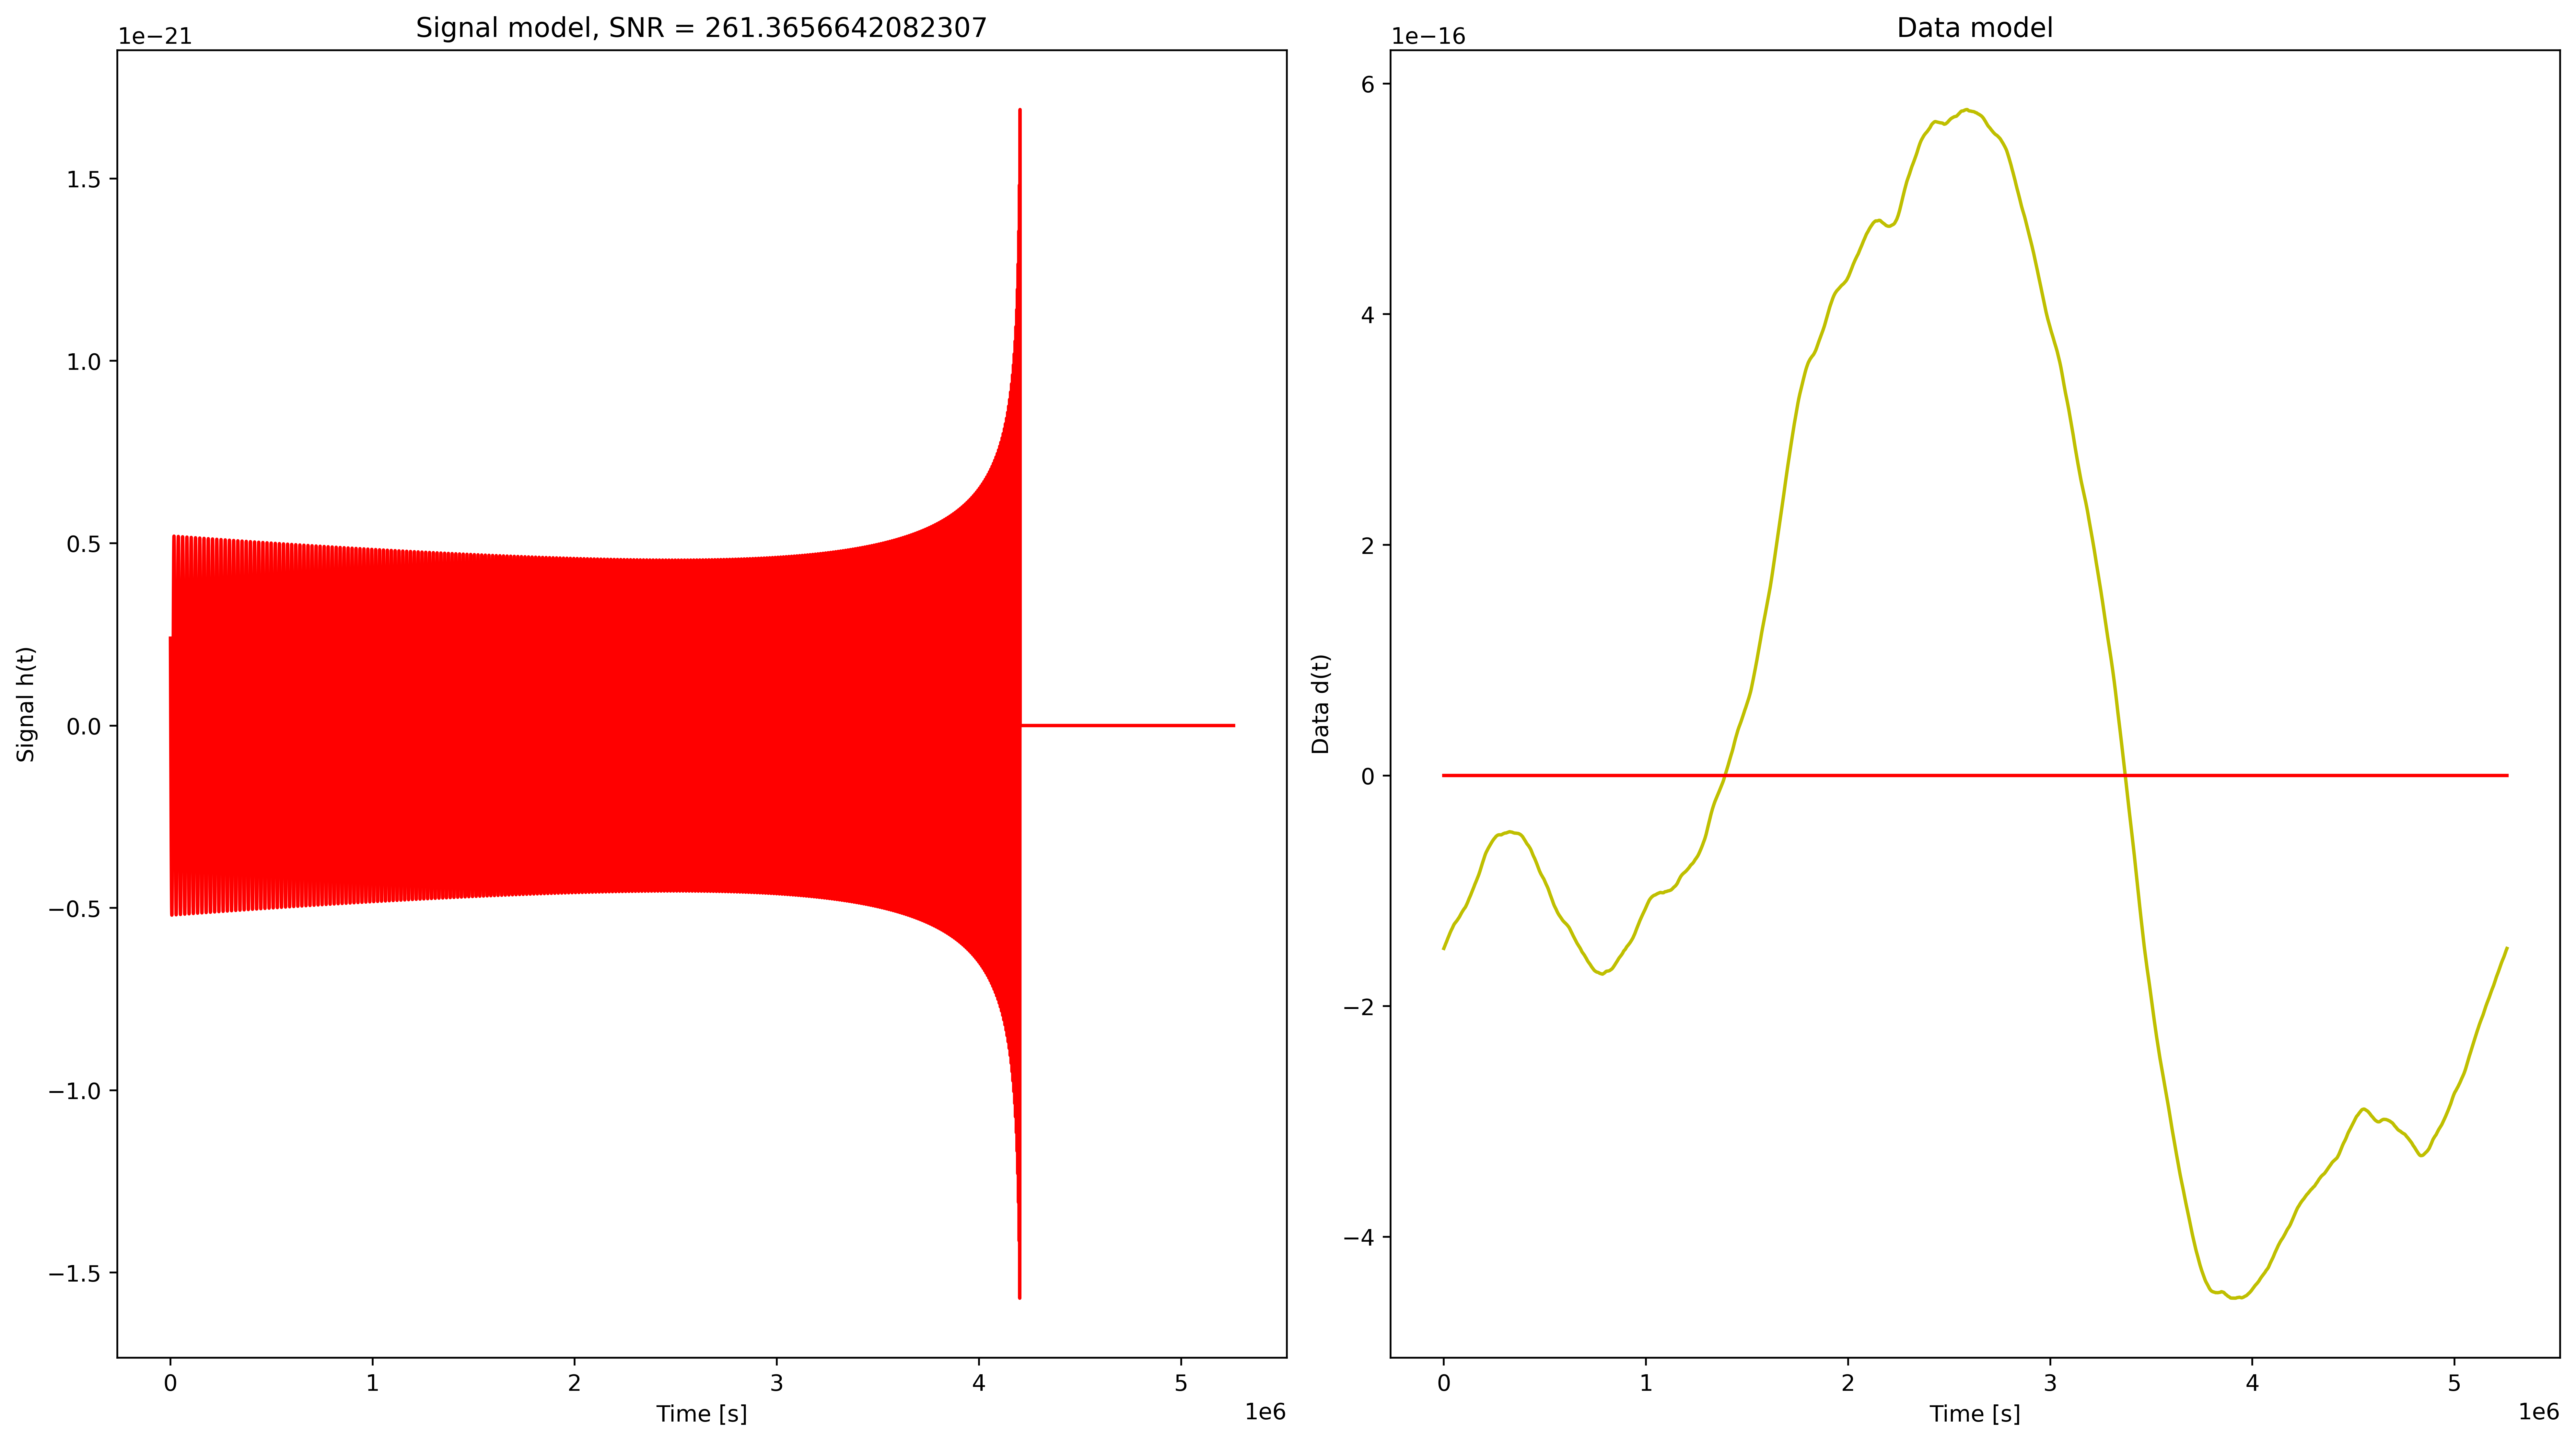

In [10]:
'''
    mutable paramters: Phic, ThetaS, Phis, Iota, Psi, M1, M2
'''
MsunInS = (const.M_sun * const.G/const.c**3).to(u.s).value # 4.926860879228572e-06   # solar mass in [s] GM/C^3
MpcInS  = (1* u.Mpc/const.c).to(u.s).value # 102927125053532.6       # mega parsec in [s]
OrbitRadiusInS = 1e8 /const.c.value    # 1e5 km
MearthInS      = const.M_earth.value*const.G.value/const.c.value**3
OrbitPeriodInS = 2*np.pi*np.sqrt(OrbitRadiusInS**3/MearthInS)
AUInS   = const.au.value/const.c.value  # AU in [s]
Tc     = 0.8*T    # chirp time

Phic   = 0.954      # chirp phase
ThetaS = 1.325      # sky location
PhiS   = 2.04       # sky location
Iota   = 1.02
Psi    = 0.658
# ThetaS = np.arccos(np.random.uniform(-1,1)) 
# PhiS   = np.random.uniform(0,2*np.pi) 
# Iota   = np.arccos(np.random.uniform(-1,1)) 
# Psi    = np.random.uniform(0,2*np.pi)  
# print(ThetaS,PhiS,Iota,Psi)

Z      = 10     # cosmological redshift
M1sun  = 1e5    # solar mass as unit
M2sun  = 1e6    # solar mass as unit
# Tobs   = 0.5   # year as unit 
# Chi1   = 0.1    # dimensionless parameter
# Chi2   = 0.0    # dimensionless parameter
cosmo  = FlatLambdaCDM(H0=67,Om0=0.32)
DL     = cosmo.luminosity_distance(Z).value*MpcInS # Mpc in second
M1     = (1+Z)*M1sun*MsunInS   # solar mass in second
M2     = (1+Z)*M2sun*MsunInS   # solar mass in second
M      = M1 + M2               # total mass
Qmr    = M1/M2                 # mass ratio
Mu     = M1*M2/M               # reduced mass
Mc     = Mu**(3./5)*M**(2./5)  # chirp mass
Eta    = M1*M2/M**2            # symmetric mass ratio
tc_true     = Tc
phic_true   = Phic
mc_true     = Mc
eta_true    = Eta
dl_true     = 50*DL
thetas_true = ThetaS
phis_true   = PhiS
iota_true   = Iota
psi_true    = Psi


h_t = ht_model(t, tc_true, phic_true, mc_true, eta_true, dl_true, thetas_true, phis_true, iota_true, psi_true)
Data = h_t + noise

snr_lisa = SNR(data=h_t, T=T, fs=fs, detector='LISA')

plt.figure(figsize=(16,9),dpi=500)
plt.subplot(1,2,1)
plt.plot(t,h_t, color='r')
plt.title('Signal model, SNR = ' + str(snr_lisa))
plt.xlabel('Time [s]')
plt.ylabel('Signal h(t)')
plt.subplot(1,2,2)
plt.plot(t,Data,color='y')
plt.plot(t,h_t, color='r')
plt.title('Data model')
plt.xlabel('Time [s]')
plt.ylabel('Data d(t)')
plt.tight_layout()
plt.savefig('data-model' + str(fs) + str(snr_lisa) + '.png', dpi=300)

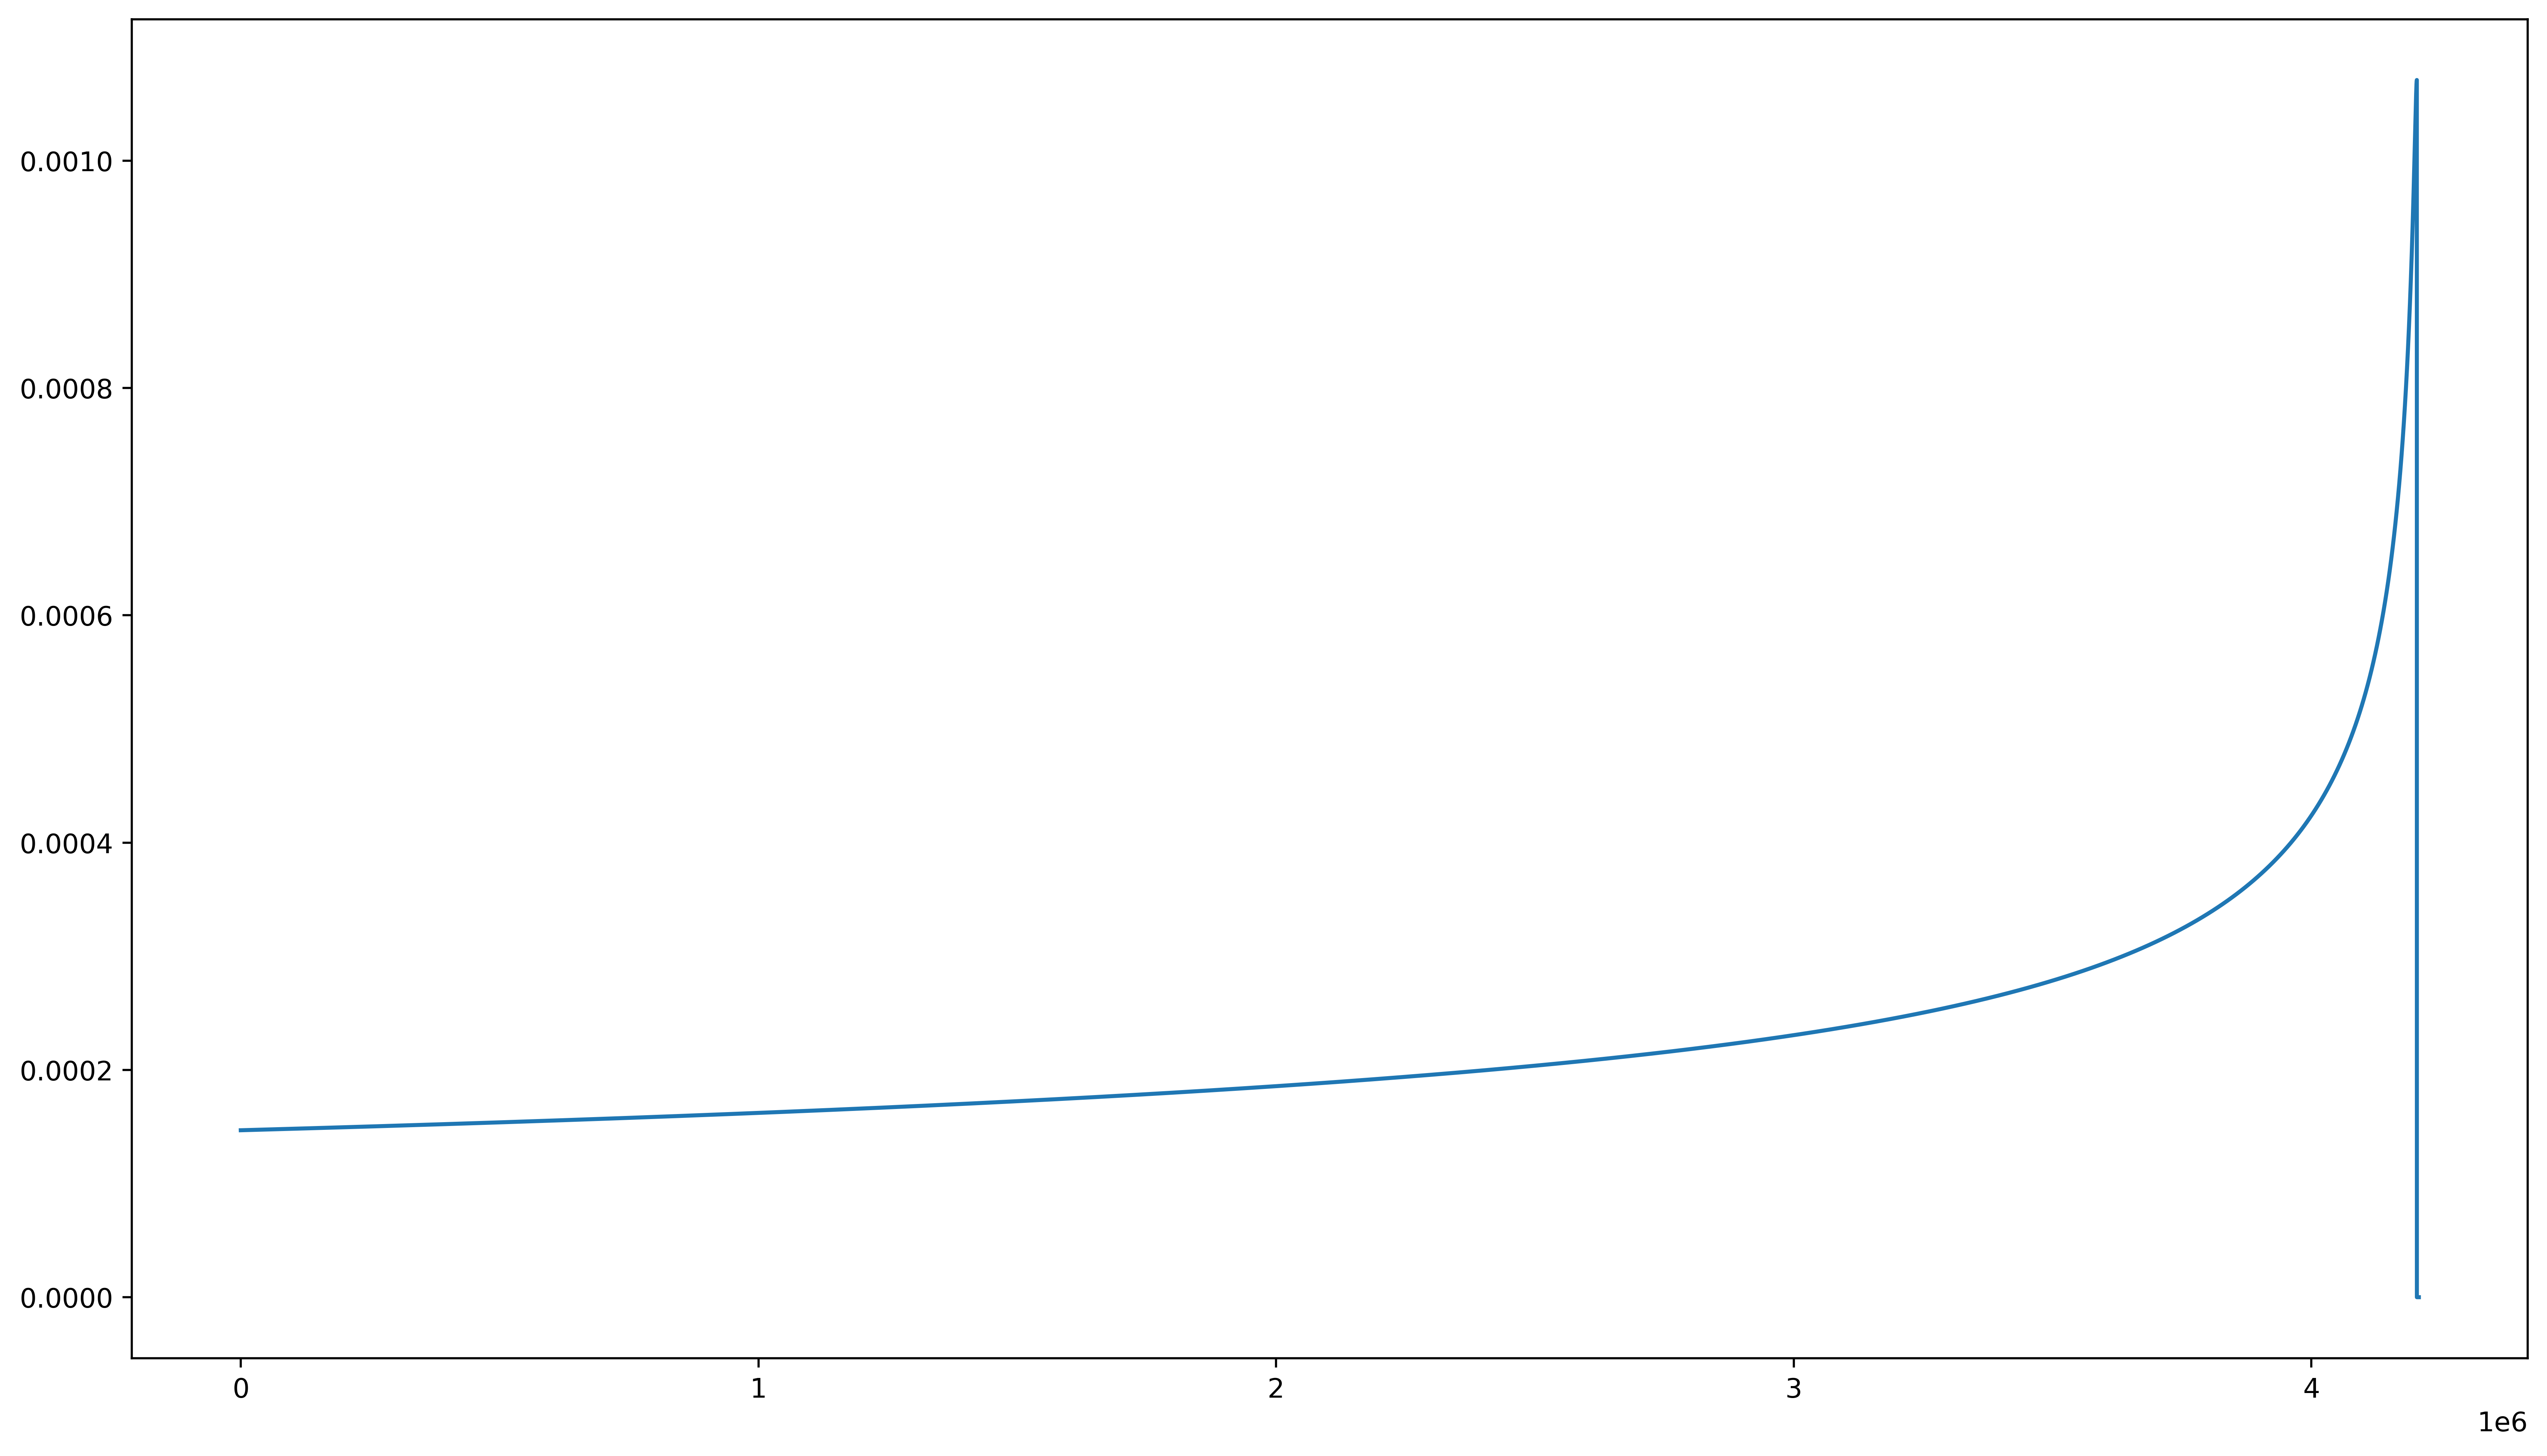

In [11]:
t1 = [tt for tt in t if tt < Tc]
t1_array = np.array(t1)
THETA = [Eta*(Tc-tt)/(5*Mc/Eta**(3./5)) for tt in t1]
PSI_PN = [Phic-t**(5./8)/Eta *(1 \
        + (3715./8064 + 55./96*Eta)*t**(-1./4) \
        - 3*np.pi/4*t**(-3./8)  \
        + (9275495./14450688+284875./258048*Eta+1855./2048*Eta**2)*t**(-1./2)) for t in THETA]

c = 1
G = 1
f_iso = c**3/(G*M*np.pi*6**(3/2)) #最内稳定圆轨道的引力波频率
tau = c**3 * Eta / (5 * G * M) * (Tc - t1_array)
w = c**3 / (8 * G * M) * (tau**(-3/8) + (743 / 2688 + 11 / 32 * Eta) * tau**(-5/8) - 3 * np.pi / 10 * tau**(-3/4) +
        (1855099 / 14450688 + 56975 / 258048 * Eta + 371 / 2048 * Eta**2) * tau**(-7/8))
# if any(x >= f_iso*np.pi for x in w):
#         index = next(i for i, x in enumerate(w) if x >= f_iso*np.pi)
#         t1 = t1[:index]
#         w = w[:index]
#         PSI_PN = PSI_PN[:index]

# find the index for max(w)
index = np.argmax(w)
# set the value of w to zero after the index
w[index:] = 0

# plot PSI_PN
plt.figure(figsize=(16,9),dpi=500)
plt.plot(t1,w)

In [12]:
print(f' max w {max(w)}, inermost stable circular orbit {f_iso*np.pi}')

 max w 0.0010710656708763982, inermost stable circular orbit 0.0011416637954187634


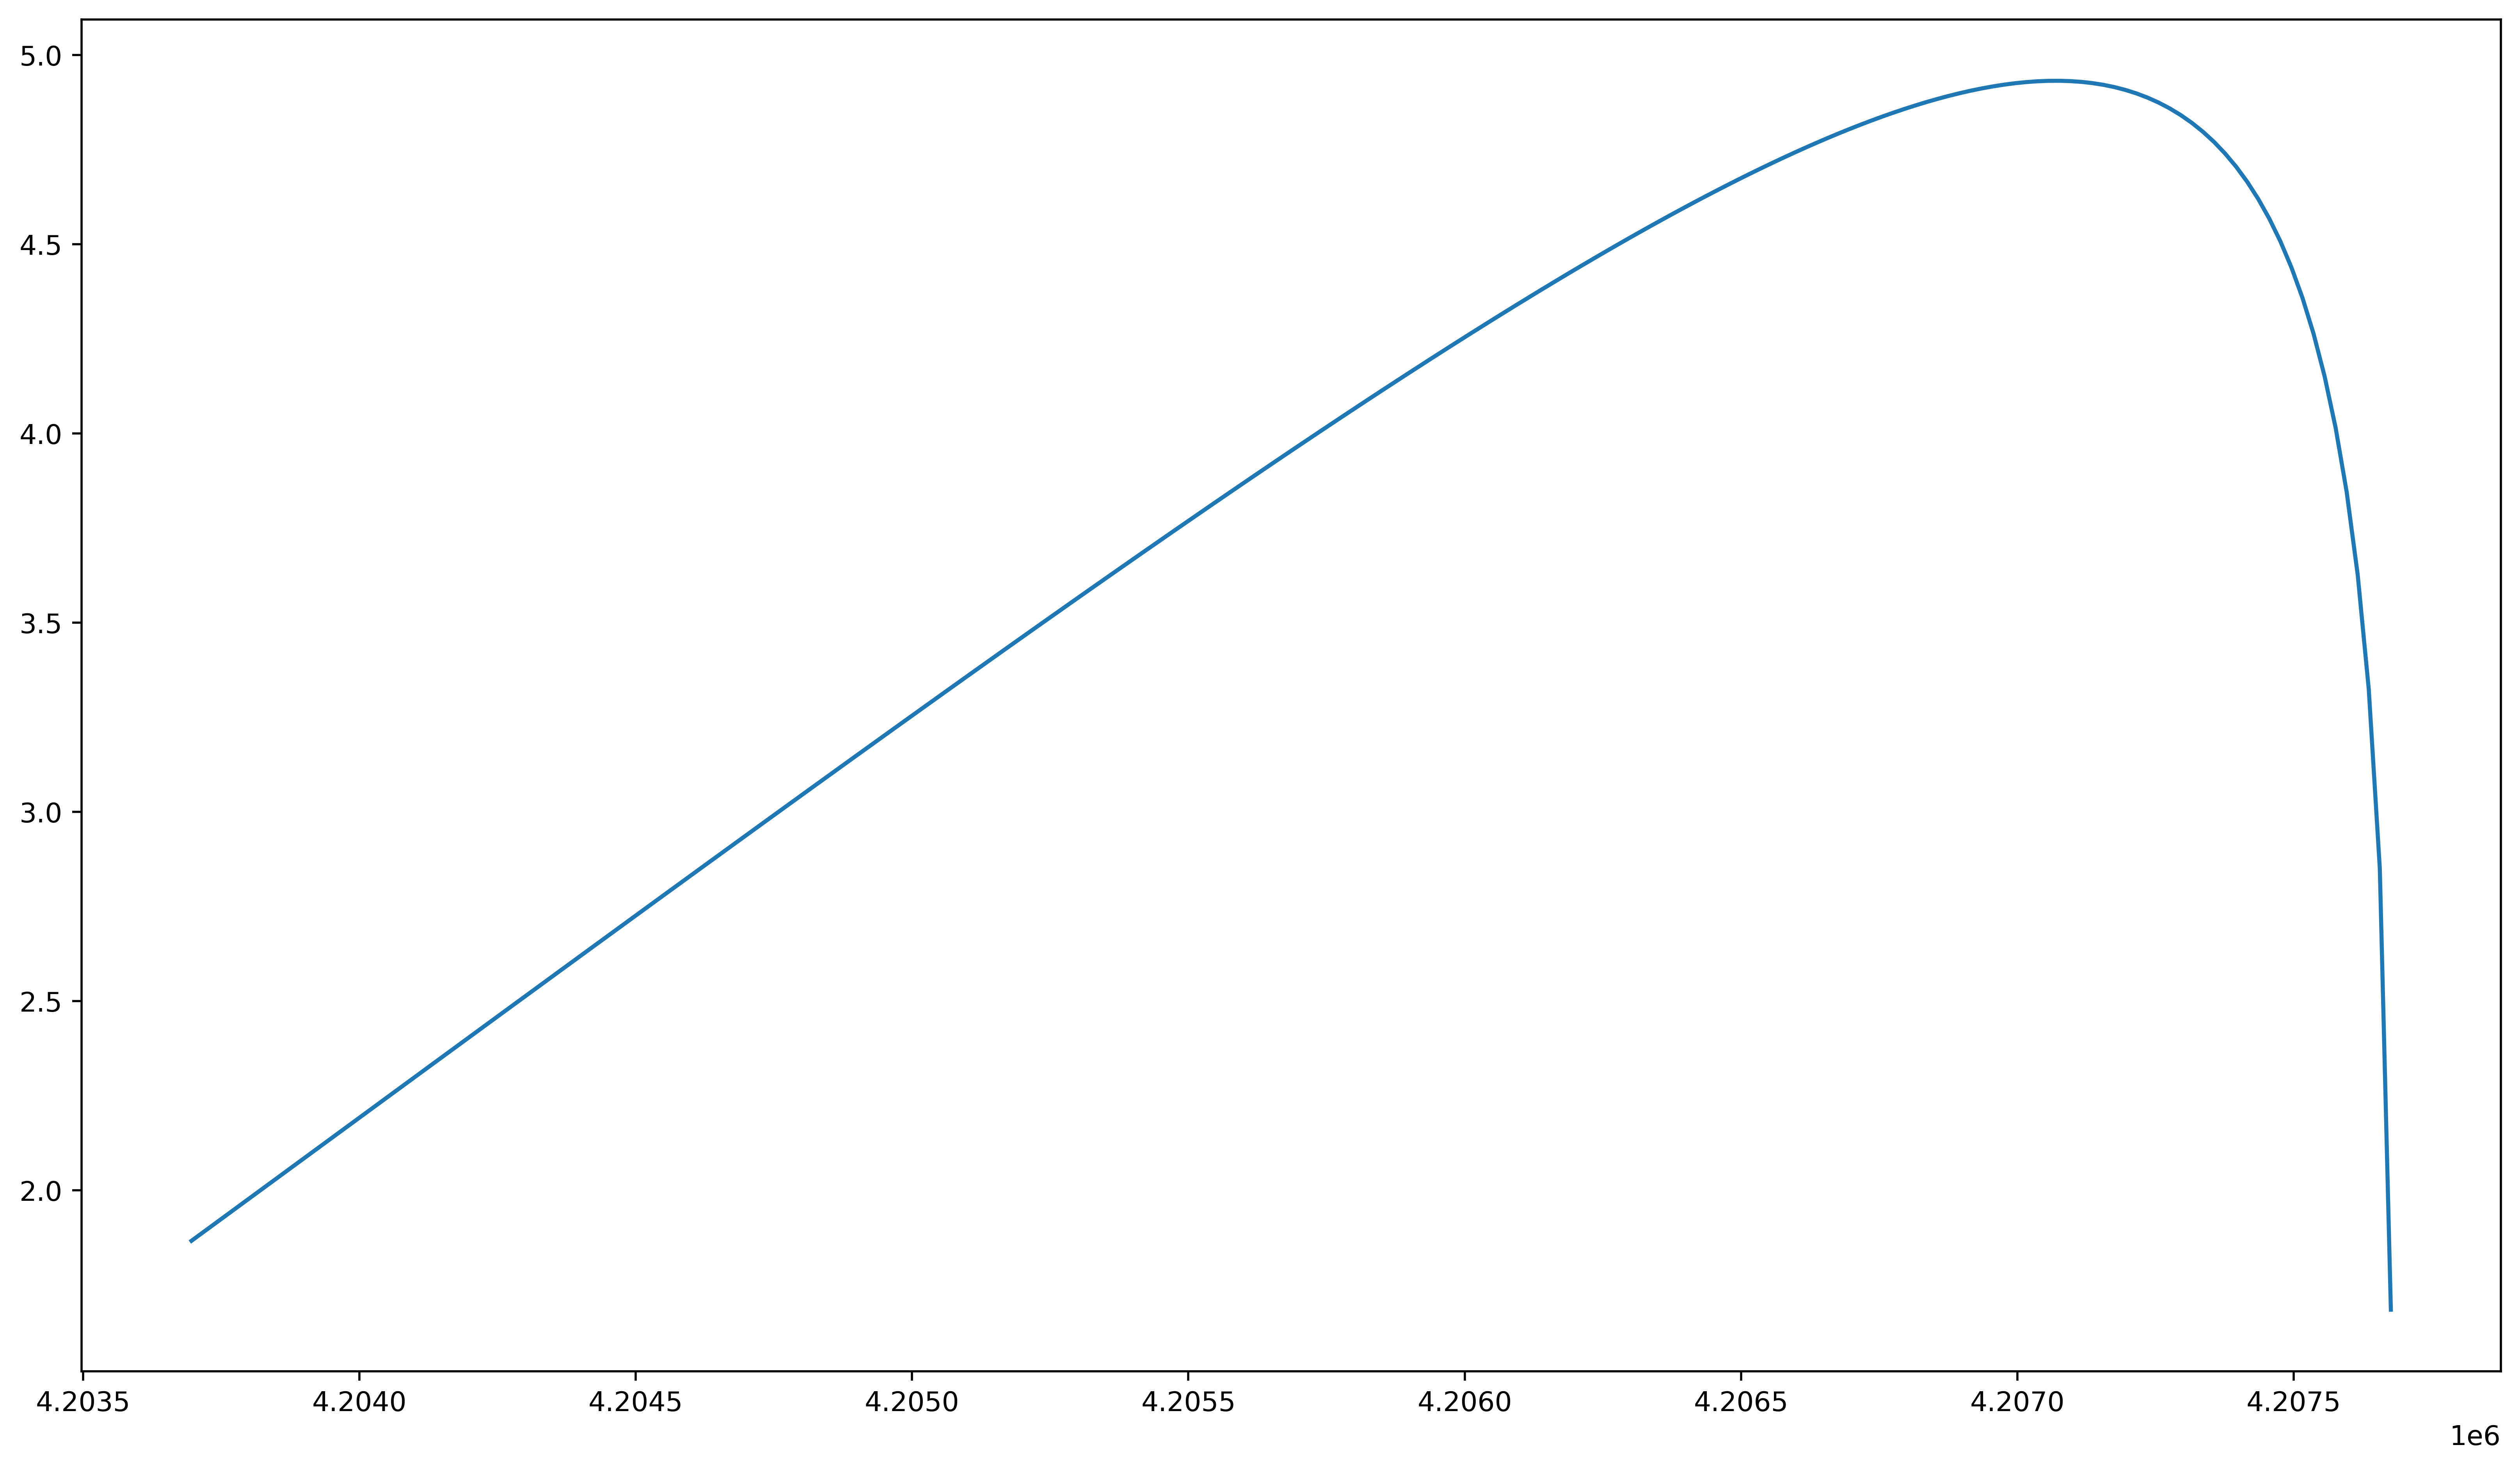

In [13]:
# plot last 200 points for t1 and PSI_PN
plt.figure(figsize=(16,9),dpi=500)
plt.plot(t1[-200:],PSI_PN[-200:])

In [14]:
# whiten Data
fft_Data = np.fft.fft(Data)
# rfft_Data = np.fft.rfft(Data)
# print(f'Length of FFT {len(fft_Data)}, length of rFFT {len(rfft_Data)}')
white_Data = fft_Data/np.sqrt(PSD2)
# set the first and last element to zero
white_Data[0] = 0
# white_Data[-1] = 0
White_Data_t = np.real(np.fft.ifft(white_Data))

# whiten the signal h_t
fft_h_t = np.fft.fft(h_t)
white_h_t = fft_h_t/np.sqrt(PSD2)
# set the first and last element to zero
white_h_t[0] = 0
# white_h_t[-1] = 0
White_h_t = np.real(np.fft.ifft(white_h_t))

# whiten colored noise
fft_Noise = np.fft.fft(noise)
white_Noise = fft_Noise/np.sqrt(PSD2)
# set the first and last element to zero
white_Noise[0] = 0
# white_Noise[-1] = 0
White_Noise_t = np.real(np.fft.ifft(white_Noise))

/var/folders/8j/473p19jj4vd201q3fw1x8flw0000gn/T/ipykernel_40439/1569559264.py:5: RuntimeWarning: divide by zero encountered in divide
  white_Data = fft_Data/np.sqrt(PSD2)
/var/folders/8j/473p19jj4vd201q3fw1x8flw0000gn/T/ipykernel_40439/1569559264.py:5: RuntimeWarning: invalid value encountered in divide
  white_Data = fft_Data/np.sqrt(PSD2)
/var/folders/8j/473p19jj4vd201q3fw1x8flw0000gn/T/ipykernel_40439/1569559264.py:13: RuntimeWarning: divide by zero encountered in divide
  white_h_t = fft_h_t/np.sqrt(PSD2)
/var/folders/8j/473p19jj4vd201q3fw1x8flw0000gn/T/ipykernel_40439/1569559264.py:13: RuntimeWarning: invalid value encountered in divide
  white_h_t = fft_h_t/np.sqrt(PSD2)
/var/folders/8j/473p19jj4vd201q3fw1x8flw0000gn/T/ipykernel_40439/1569559264.py:21: RuntimeWarning: divide by zero encountered in divide
  white_Noise = fft_Noise/np.sqrt(PSD2)
/var/folders/8j/473p19jj4vd201q3fw1x8flw0000gn/T/ipykernel_40439/1569559264.py:21: RuntimeWarning: invalid value encountered in divide
 

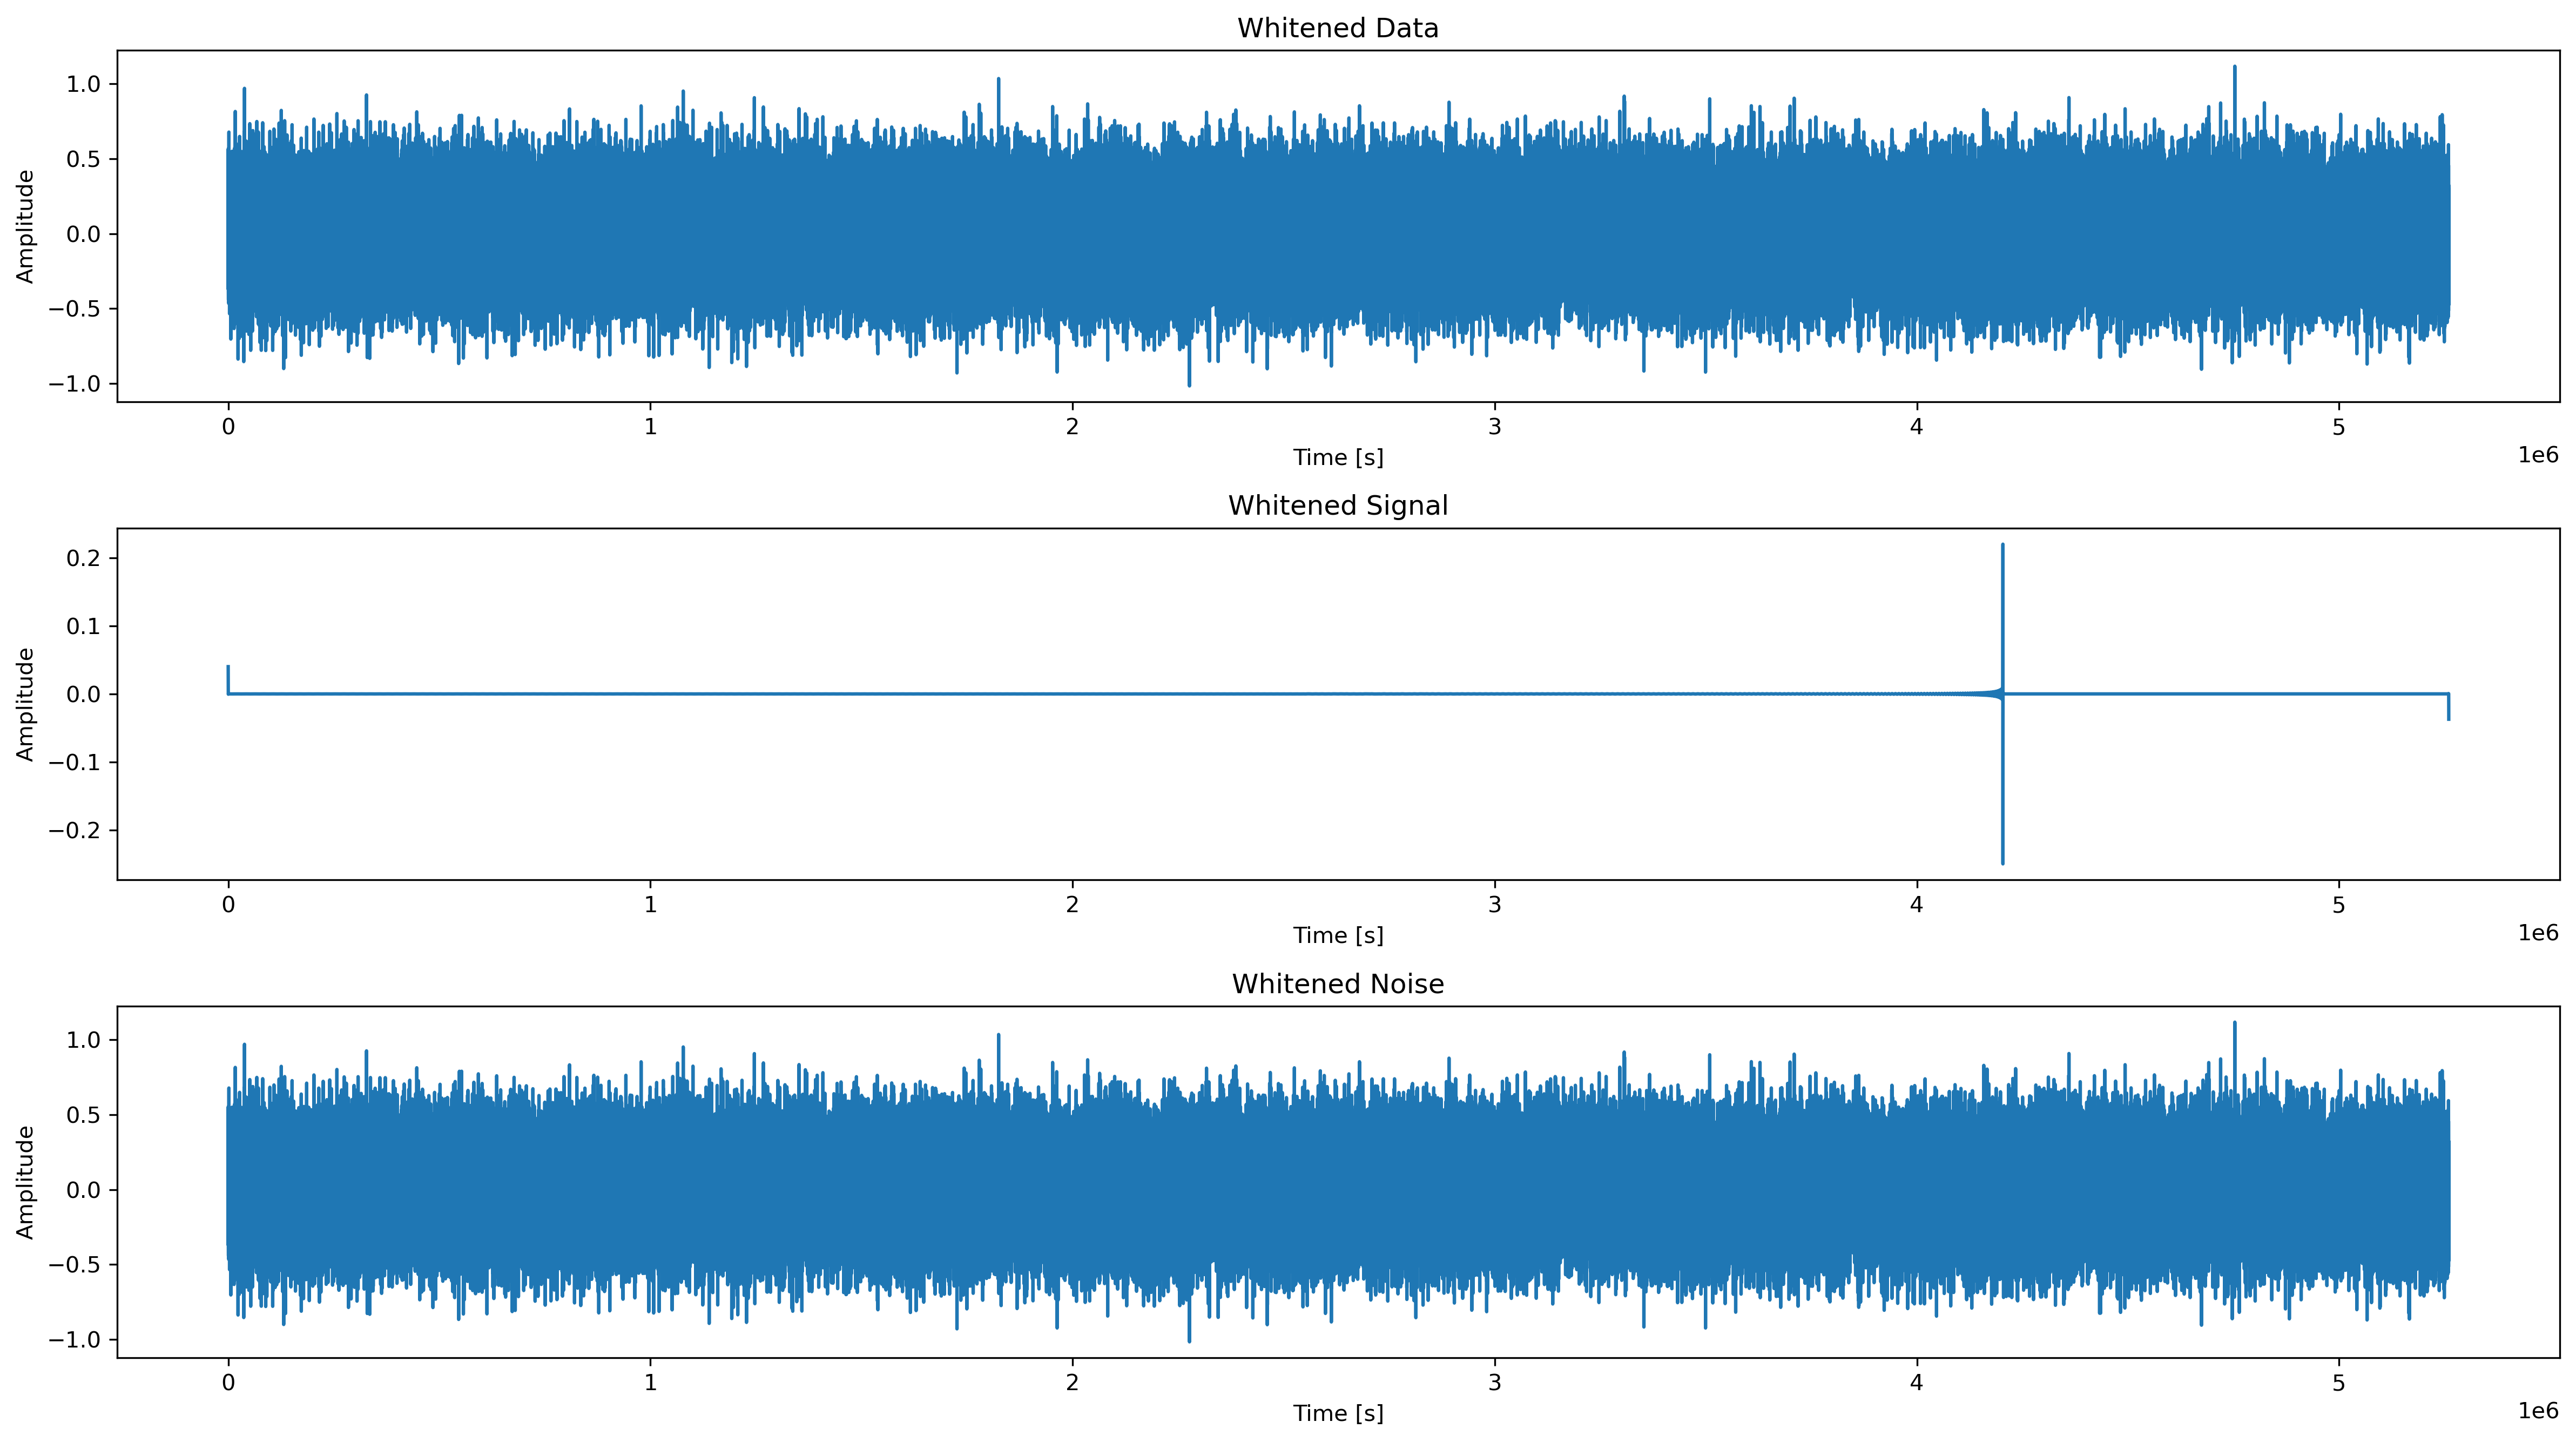

In [15]:
fig,axs = plt.subplots(3, 1, figsize=(16,9),dpi=300)

axs[0].plot(t, White_Data_t)
axs[0].set_title('Whitened Data')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Amplitude')

axs[2].plot(t, White_Noise_t)
axs[2].set_title('Whitened Noise')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Amplitude')

axs[1].plot(t, White_h_t)
axs[1].set_title('Whitened Signal')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.savefig('whitened-data-noise-signal' + str(fs) + str(SNR) + '.png', dpi=300)


In [16]:
Tc

4207680.0

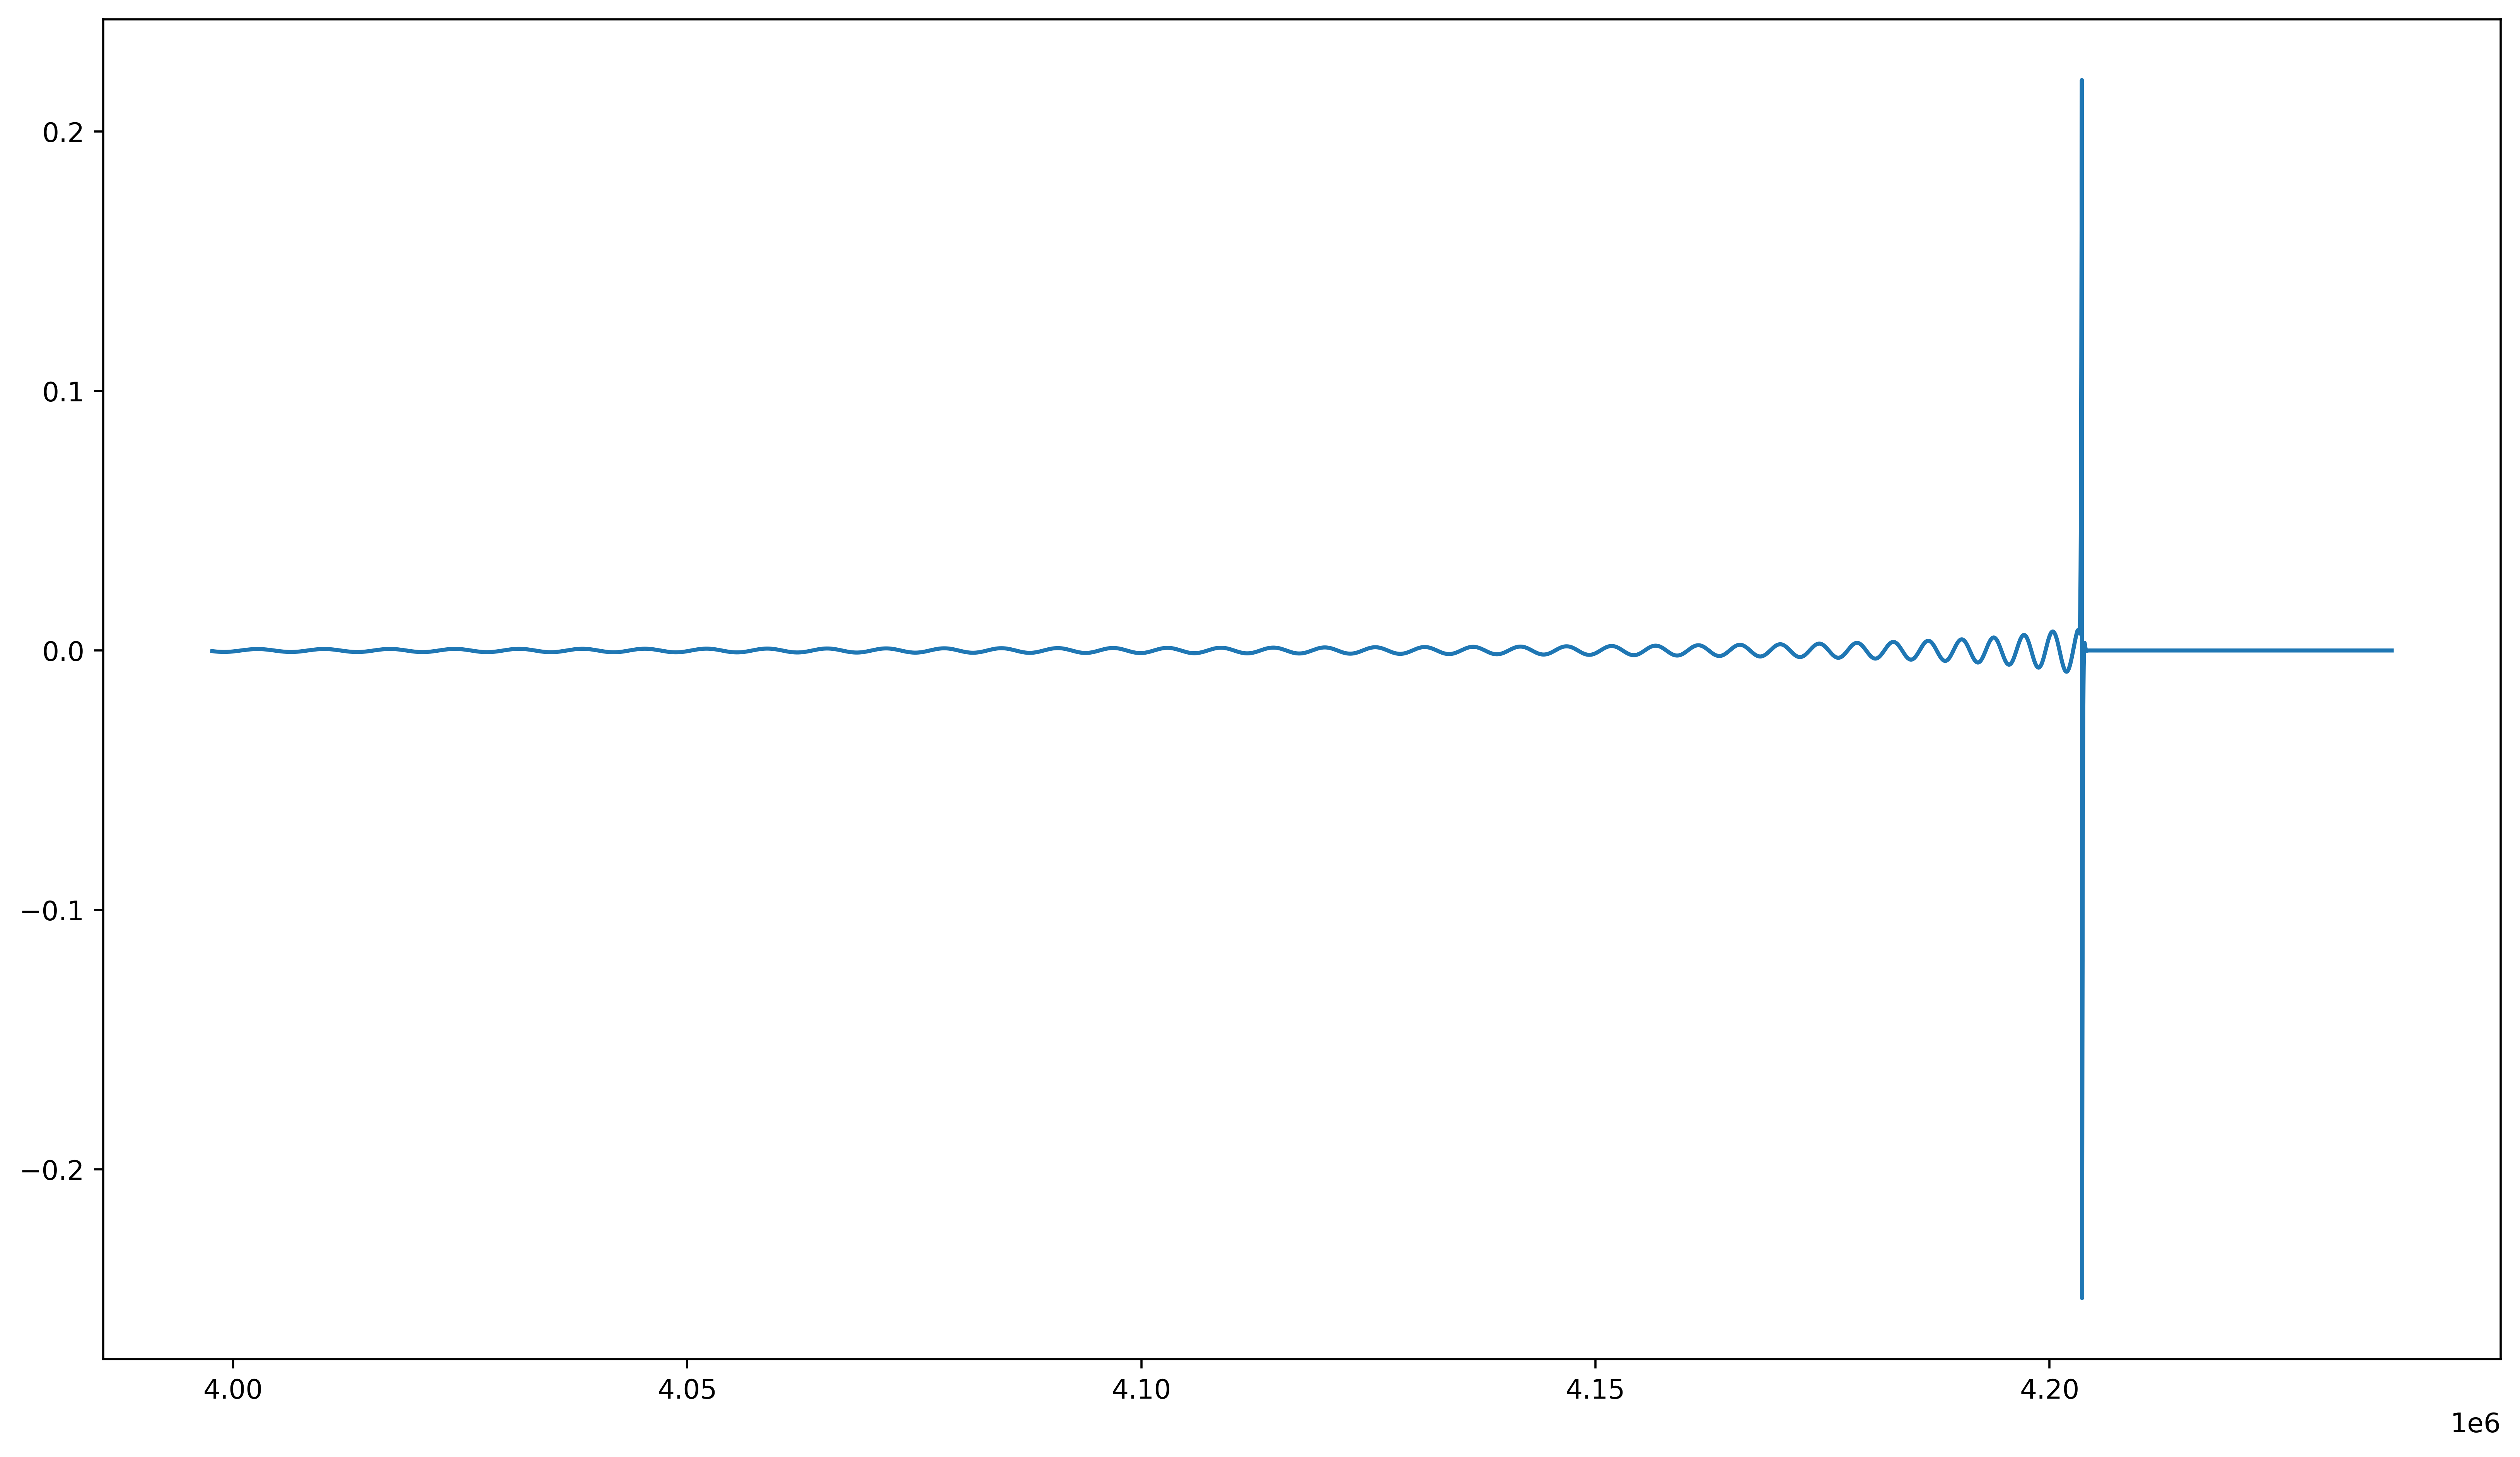

In [22]:
# set the figsize
plt.figure(figsize=(16,9),dpi=500)
plt.plot(t[int(Tc/20 - 10500):int(Tc/20 + 1500)], White_h_t[int(Tc/20 - 10500):int(Tc/20 + 1500)])

